# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Advanced Lane Finding

The goal of this project is to write a software pipeline to identify the lane boundaries in a video. Concretely, the pipeline needs to handle a series of tasks including image undistorsion, lane line pixel detection, curve fitting, curvature/position derivation, averaging results from recent frames, and finally, imposing the fitted curves onto the original image.

The following figure summarizes the entire pipeline and highlights the action to take at each step and its associated functions/class. The 'process_image()' function incorporates all the steps. The 'visualization functions' listed in the lower left corner are not part of the flow, but are critical to view intermediate results for diagnosing and debugging. The graph has included all functions and classes defined in the codes.

The final video output is saved in 'project_video_lines.mp4'.

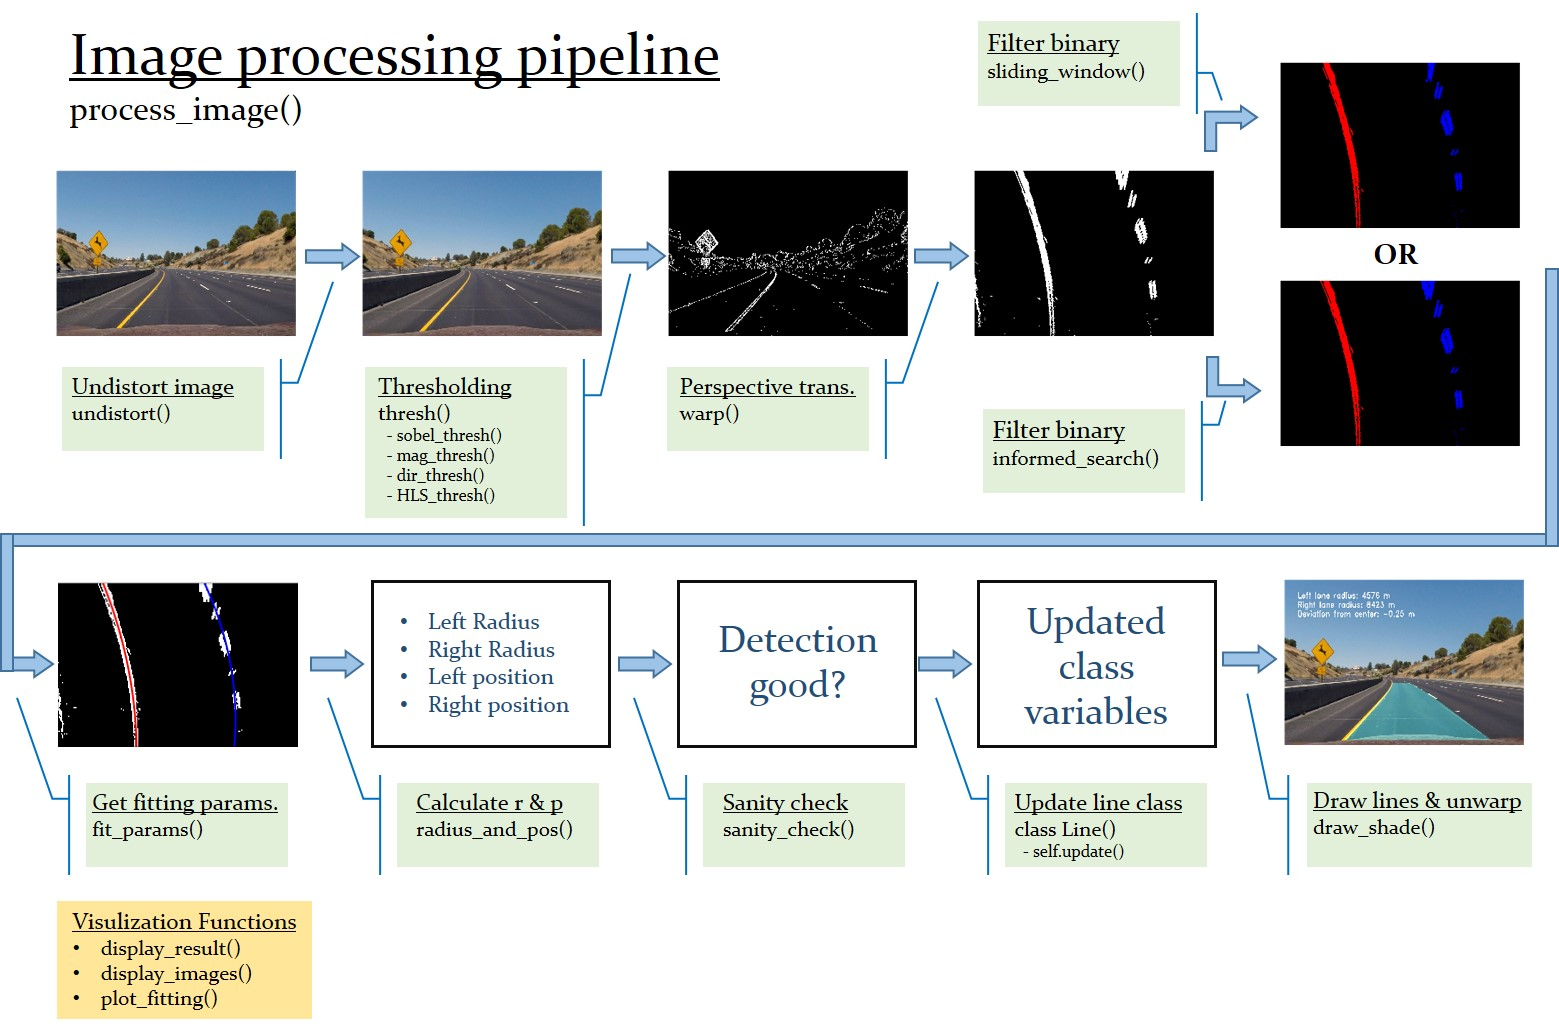

In [73]:
from IPython.display import Image
Image(filename='../advanced_lane_finding/output_images/summary.jpg') 

For implementation I have devided the work into 8 steps, each taking care of a specific task. Relavant functions are defined in the corresponding sections. Test images are loaded and inspected after each processing step.
- Step 0: Import libraries and define the visualization functions
- Step 1: Calibrate camera and define an image undistorsion function.
- Step 2: Perform gradient and color thresholding on the images as the first-round screening of the pixels. This creates a binary image that highlights candidate pixels.
- Step 3: Take perspective transform of the binary image and create a bird's eye view.
- Step 4: Use histogram and sliding-window method to further screen the pixels on the warped binary image; Select and separate the pixels from the left and right lane lines.
- Step 5: Perform a polynomial fitting for the selected pixels, derive the fitting parameters, and calculate line curvatures and positions.
- Step 6: Draw the fitting lines/shade on the original image; Print radius of curvature and car position as annotation on each frame.
- Step 7: Put things together: Define an alternative pixel-screening function ('informed_search()') to replace 'sliding_window()' when previous detection is successful; Evaluate the output curvature and position values and update Line() class accordingly; Package all the above steps into a singel function 'process_image()'.

Now let's look into each step.

---
## Step 0. Import Libraries and Define Visualization Functions

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Display an image before and after a function is applied, 
# in the left and right figure.
def display_result(func, img, *arg, **kwarg):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    #f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(func(img, *arg, **kwarg), cmap='gray')
    ax2.set_title('Processed Image', fontsize=16)
    #temp = plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Display multiple images in a 2D grid
def display_images(imgs, n_cols=3):
    n_images = len(imgs)
    n_rows = int(np.ceil(n_images/n_cols))
    
    # Setup figures
    fig = plt.figure(figsize=(30, 6*n_rows), dpi=32)
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.1)
    ax = [plt.subplot(gs[i]) for i in range(n_images)]

    # Plot images
    for i in range(n_images):
        ax[i].imshow(imgs[i], cmap='gray')
        ax[i].set_xlabel(str(i+1), fontsize=26)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

In [4]:
# Draw fitting lines on warped binary images
def plot_fitting(warped_binaries, n_cols=3):
    n_images = len(warped_binaries)
    n_rows = int(np.ceil(n_images/n_cols))
    
    # Setup figures
    fig = plt.figure(figsize=(30, 6*n_rows), dpi=32)
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.2)
    ax = [plt.subplot(gs[i]) for i in range(n_images)]

    # Plot images
    for i in range(n_images):
        # Process input binary to obtain fitting parameters
        filtered_binary = sliding_window(warped_binaries[i], 10, 100)
        left_fit, right_fit = fit_params(filtered_binary, xm_per_pix=1, ym_per_pix=1)
        
        # Prepare x, y data
        y = np.linspace(0, 100, num=101)*7.2
        left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        
        # Plot fitting curves
        ax[i].plot(left_fitx, y, color='red', linewidth=4)
        ax[i].plot(right_fitx, y, color='blue', linewidth=4)
        plt.gca().invert_yaxis()
        
        # Append input binary to the image; Add labels; Remove ticks
        ax[i].imshow(warped_binaries[i], cmap='gray')   
        ax[i].set_xlabel(str(i+1),fontsize=26)
        ax[i].set_xticks([])
        ax[i].set_yticks([])        

---
## Step 1. Camera Calibration and Image Undistortion

The codes start from camera calibration by analizing a set of chessboard pictures and correlating the corner locations with the points on an undistorted grid. I then use opencv's calibrateCamera() function to generate camera matrix 'mtx' and distortion coefficients 'dist' and use them to define the undistort() function.

In [5]:
# The following codes are from Udacity lecture
# Make a list of calibration image names
cal_img_path = '../advanced_lane_finding/camera_cal/calibration'
img_names = glob.glob(cal_img_path + '*.jpg')

# Prepare for image and object calibration lists 
n_rows = 6
n_cols = 9
imgpoints = []
objpoints = []

objpoint = np.zeros((n_rows * n_cols, 3), np.float32)
objpoint[:,:2] = np.mgrid[:n_cols,:n_rows].T.reshape(-1,2)

for fname in img_names:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (n_cols,n_rows), None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objpoint)
    else:
        print('Sample {:s} fails corner detection'.
              format(fname.strip(cal_img_path).strip('.jpg')))

# Perform Camera Calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   img.shape[:2],
                                                   None, None)
# Use the calibraion coefficients to define undistort function
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

Sample \calibration1 fails corner detection
Sample \calibration4 fails corner detection
Sample \calibration5 fails corner detection


One of the chessboard images is loaded to verify the undistort() function. The left and right images are before and after undistortion, respectively.

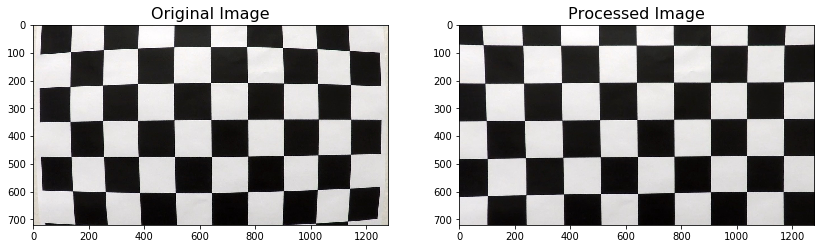

In [6]:
# Load a test image for verification
display_result(undistort, mpimg.imread('camera_cal/calibration1.jpg')) 

Read test images from the 'test_images' folder to inspect the result after image undistortion:

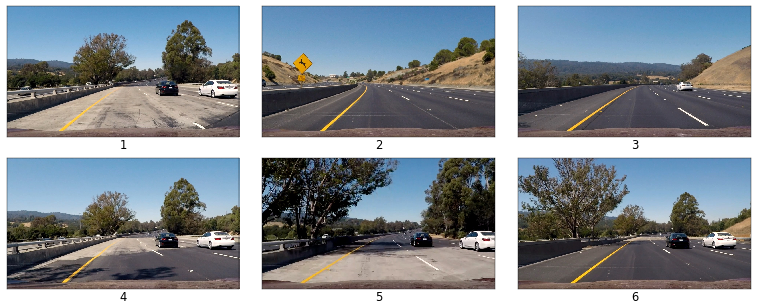

In [7]:
# Read and display test images
test_img_path = '../advanced_lane_finding/test_images/'
img_names = glob.glob(test_img_path + 'test*.jpg')
raw_images = [mpimg.imread(x) for x in img_names]
display_images(raw_images)

The output images of the undistort() function are shown below. The difference is very subtle from the images above. Changes are only visible near image edges.

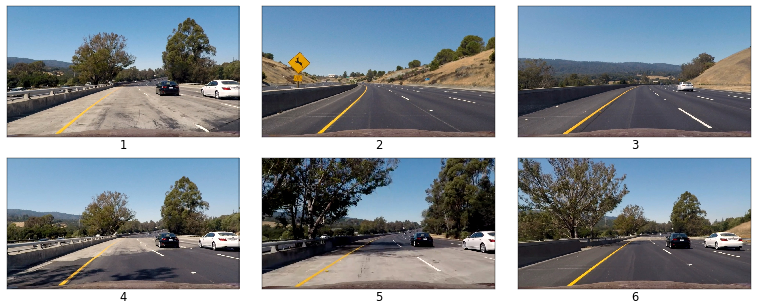

In [8]:
# Undistort images
images = [undistort(x) for x in raw_images]
display_images(images)

---
## Step 2. Gradient and Color Thresholding

To begin with, I first define a set of functions for gradient (x, y, magnitude and direction) and color thresholding. The four functions, 'sobel_thresh()', 'mag_thresh()', '(dir_thresh()' and 'HLS_thresh()' are then packaged into a single function 'thresh()' in the end. We note that only the 'sobel_thresh()'(for x-gradient thresholding) and 'HLS_thresh()'(for S value thresholding) functions are activated in the 'thresh()' package. I have experimented with numerous combinations. This particular setting used in the following codes (together with the respective threshold setting) worked reasonably well.

In [9]:
# Sobel thresholding function
def sobel_thresh(img, axis='x', sobel_kernel=3, thresh=(30,150)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif axis == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print('Invalid axis input')
        return
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

In [10]:
# Gradient magnitude thresholding function
def mag_thresh(img, sobel_kernel=3, thresh=(30,100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx ** 2 + sobely ** 2) 
    scaled_mag = np.uint8(255 * mag / np.max(mag))
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1
    return mag_binary

In [11]:
# Gradient direction thresholding function
def dir_thresh(img, sobel_kernel=3, thresh=(0.8,1.1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))    
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

In [12]:
# HLS color space thresholding function
def HLS_thresh(img, channel='S', thresh=(90, 250)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'H':
        mono = hls[:,:,0]
    elif channel == 'L':
        mono = hls[:,:,1]
    elif channel == 'S':
        mono = hls[:,:,2]
    else:
        print('Invalid channel input')
        return np.zeros_like(mono)
    binary = np.zeros_like(mono)
    binary[(mono >= thresh[0]) & (mono <= thresh[1])] = 1
    return binary

In [13]:
# Thresholding pipeline function
def thresh(img):
    # Gradient thresholding
    ksize = 3
    gradx = sobel_thresh(img, axis='x', sobel_kernel=ksize, thresh=(30, 150))
    #grady = sobel_thresh(img, axis='y', sobel_kernel=ksize, thresh=(30, 150))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(30, 100))
    #dir_binary = dir_thresh(img, sobel_kernel=ksize, thresh=(0.8, 1.1))
    
    # Color thresholding
    S_binary = HLS_thresh(img, channel='S', thresh=(170, 250))
    #L_binary = HLS_thresh(img, channel='L', thresh=(170, 250))
    #H_binary = HLS_thresh(img, channel='H', thresh=(170, 250))
    
    # Combine gradient and color thresholding
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (S_binary == 1)] = 1
    #combined[(gradx == 1) & (grady == 1) | (S_binary == 1)] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

The output of the 'thresh()' function is shown below.

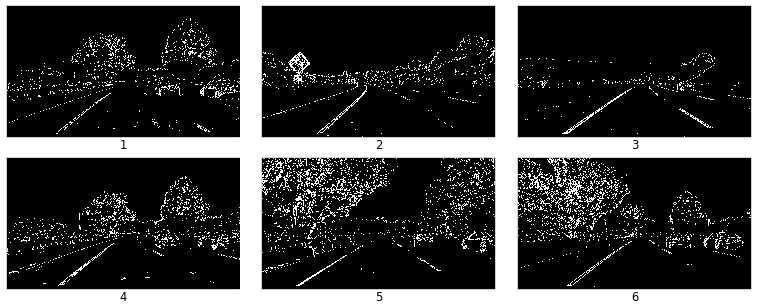

In [14]:
# Generate binary images by gradient and color thresholding
binaries = [thresh(x) for x in images]
display_images(binaries)

---
## Step 3. Perspective Transform

First we need to specify four points in a perspective image as the Source points for perspective transformation. They form a rectangle from an un-perspecitive view, but skewed in camera images. The easiest way to locate Source points is to use a picture with straight lane lines and put two points on each line, as shown below.

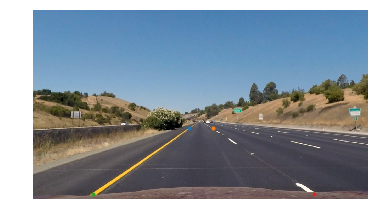

In [15]:
# Load a reference image to determine the source points 
ref_image1 = undistort(mpimg.imread(test_img_path + 'straight_lines1.jpg'))
ref_image2 = undistort(mpimg.imread(test_img_path + 'straight_lines2.jpg'))

plt.imshow(ref_image1)
plt.plot(595, 450, '.') # top left
plt.plot(687, 450, '.') # top right
plt.plot(230, 700, '.') # bottom left
plt.plot(1075, 700, '.') # bottom right
temp = plt.axis('off')

We then specify the Desitination (dst) points in the following cell, which, combined with the Source points, generate a Perspective Transform Matrix (M). The destination points are where we want the source points to locate in a bird's eye view. Reversing the order of the source and destination points can result in an inverse transformation matrix (Minv), which can be used to unwarp a top view image to perspective view.  

In [16]:
# Define M and Minv
src = np.float32([[595, 450],
                [687, 450],
                [230, 700],
                [1075, 700]])    
dst = np.float32([[360, 0],
                [920, 0],
                [360, 720],
                [920, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

The transformation matrix M is then used to define the perspective transform function warp():

In [17]:
# Define warp function using the source points from the reference image
def warp(img):    
    return cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)    

In the following cells, the warp() function is tested with a straight-line image, 6 curved_line images, and 6 binary perspective images (the output from the 'thresh()' function).

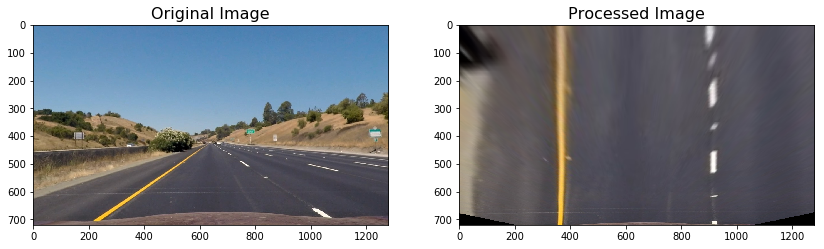

In [18]:
display_result(warp, ref_image1)

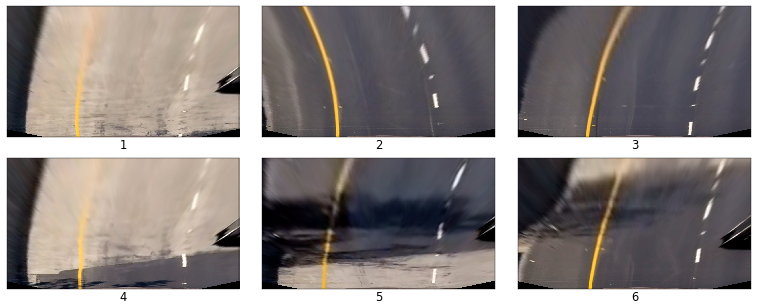

In [19]:
warped = [warp(x) for x in images]
display_images(warped)

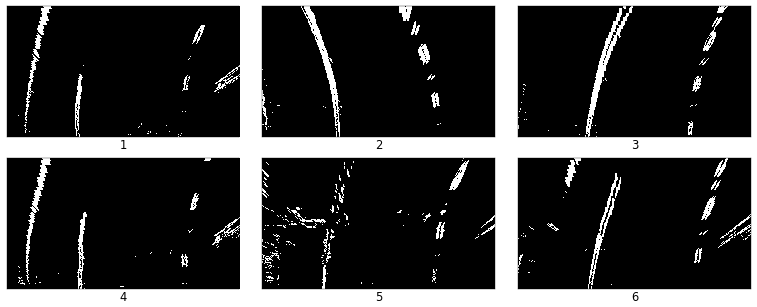

In [20]:
warped_binaries = [warp(x) for x in binaries]
display_images(warped_binaries)

---
## Step 4. Lane Detection

To identify line pixels, we first use a histogram plot of the bottom section of the image to locate the staring points of the lines. A typical histogram is shown below. It plots the number of pixels in the bottom 1/3 of the image as a function of x-coordinates. The two peaks correspond to the positions of the left and right lane lines right in front of the car. We then define two masks centered around these two positions to select inside candidate pixels and exclude pixels outside. The selected pixels are presumably lane line pixels.    

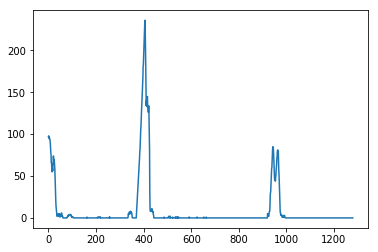

In [69]:
# Visualize histogram of a warped binary image
histogram = np.sum(test_binary[warped_binaries[1].shape[1]//3:,:], axis=0)
temp = plt.plot(histogram)

The histogram approach only works for line detection near the bottom of an image. In the following cell, I define a sliding-window function to extend the search throughout the entire height from bottom to top. The function takes in a warped binary image and splits it into typically 8-10 horizontal slices. It then conducts a histogram search for the very bottom slice, and uses the result to predict the line-positions of the upper slice. The function is able to differentiate the two lines as well. In the end, it outputs a 'color_binary' image, with the left line and right line pixels on the R and B channels, respectively. 

In [22]:
def sliding_window(binary, n_strips, width):    
    # Initialize output color binary map
    filtered = np.zeros((binary.shape[0],binary.shape[1],3), np.float32)
    
    # Calculate strip height and width
    s_height = binary.shape[0]//n_strips
    s_width = binary.shape[1]
    
    # Determine the starting left and right x-coordinates
    # Take a histogram of bottom 1/3 of the image
    # find the two initial peak positions
    hist = np.sum(binary[binary.shape[0]//3:,:], axis=0)
    lx = np.argmax(hist[:700])
    rx = 700 + np.argmax(hist[700:])
    
    # Filter strip by strip from bottom to top
    for i in reversed(range(n_strips)):
        # Take a horizontal slice of the image
        slicey = slice(i*s_height, (i+1)*s_height)
        strip = binary[slicey,:]
        
        # Prepare two masks
        slicexl = slice(max(0, (lx - width//2)), (lx + width//2))
        slicexr = slice((rx - width//2), min((rx + width//2), s_width))
        lmask = np.zeros_like(strip)
        lmask[:,slicexl] = 1
        rmask = np.zeros_like(strip)
        rmask[:,slicexr] = 1
        
        # Filter the strip and update output binary
        lsegment = np.zeros_like(strip)
        lsegment[(strip == 1) & (lmask == 1)] = 1
        filtered[slicey,:,0] = lsegment
        
        rsegment = np.zeros_like(strip)
        rsegment[(strip == 1) & (rmask == 1)] = 1
        filtered[slicey,:,2] = rsegment
        
        # Update peak positions if the new x positions are not 
        # too far away from the old positions
        new_lx = np.argmax(np.sum(lsegment, axis=0))
        new_rx = np.argmax(np.sum(rsegment, axis=0))
        lx = new_lx if (abs(new_lx - lx) < width) else lx
        rx = new_rx if (abs(new_rx - rx) < width) else rx

    return filtered

Inspect results of the sliding_window() function:

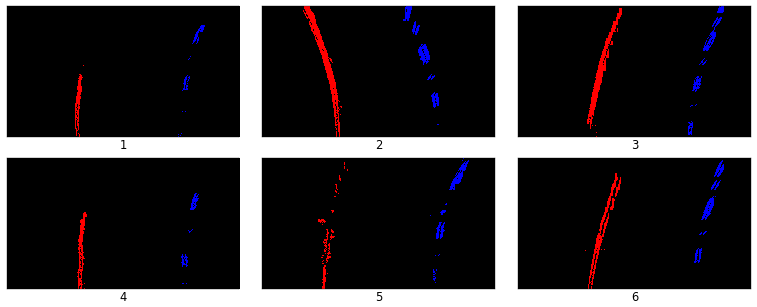

In [23]:
filtered_binaries = [sliding_window(x, 10, 100) for x in warped_binaries]
display_images(filtered_binaries)

---
## Step 5. Curve Fitting and Calculations

In this section, we use the information from the 'color_binary' images to create polynomial fittings for the lane lines. The fitting parameters would allow us to reconstruct lane boundaries and derive important information such as radius of curvature and car position with respect to the lanes.

The following calculation involves a couple of important parameters related to pixel-to-meter conversions. The next cell defines and explains them.

In [24]:
# Meters per pixel
xratio = 3.7/560
yratio = 26/720

# Conversion coefficient from 'meter' fit parameters to
# 'pixel' fit parameters. i.e.,
# fit_pixel * conversion_coef = fit_m
conversion_coef = (5.06677937, 0.18296703, 0.00660714)

The following fit_params() function reads in a 'color-binary' image, performs the polynomial fitting, and returns the fitting parameters for the left and right lines as two separate variables. 

In [25]:
def fit_params(c_binary, xm_per_pix=xratio, ym_per_pix=yratio):
    h = c_binary.shape[0]
    w = c_binary.shape[1]
    
    # Prepare x oordinates
    #xv,_ = np.meshgrid(np.array(range(w)),np.array(range(h)))
    xv,_ = np.mgrid[0:h,0:w]
    lmatrix = xv * c_binary[:,:,0]
    rmatrix = xv * c_binary[:,:,2]
    
    # Remove all-zero rows
    lboolean = lmatrix.any(axis=1)
    rboolean = rmatrix.any(axis=1)
    lmatrix = lmatrix[lboolean]
    rmatrix = rmatrix[rboolean]
    lx = np.array([np.mean(np.nonzero(row)) for row in lmatrix])
    rx = np.array([np.mean(np.nonzero(row)) for row in rmatrix])
    
    # Prepare y coordinates
    y = np.array(range(h))
    ly = y[lboolean]
    ry = y[rboolean]
    
    # Polynomial Fitting
    left_fit = np.polyfit(ly*ym_per_pix, lx*xm_per_pix, 2)
    right_fit = np.polyfit(ry*ym_per_pix, rx*xm_per_pix, 2)   
   
    return left_fit, right_fit

In [26]:
# Save fit parameters for all test images
fit_parameters = [fit_params(filtered_binaries[i], 1, 1) for i in range(6)]

Plot fitting lines on the warped-binary images to verify the fit_params() function:

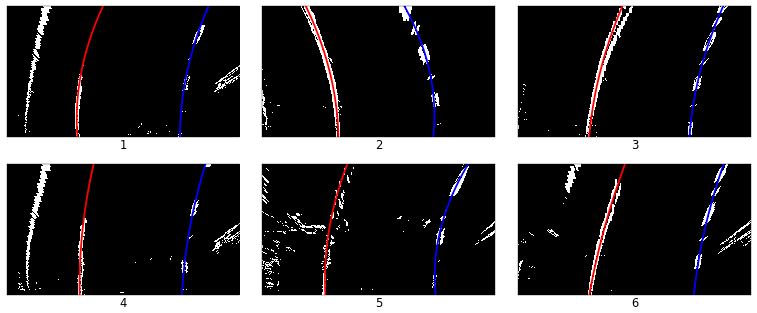

In [27]:
plot_fitting(warped_binaries)

The function below, radius_and_pos() uses the fitting parameters to calculate lane line radii and positions. 

In [28]:
def radius_and_pos(fit_coef):
    # Convert 'pixel' fitting coefs to 'meter' fitting coefs
    fit = fit_coef * conversion_coef

    # Calculate radius of curvature at the bottom of the image
    y_eval = 720 
    curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / abs(2*fit[0])
   
    # Calculate line positions at the bottom of the image
    bottom_y = 720 * yratio
    bottom_x = fit[0]*bottom_y**2 + fit[1]*bottom_y + fit[2]
    return curverad, bottom_x           

In [29]:
left_radii_positions = [radius_and_pos(fit_parameters[i][0]) for i in range(6)]
right_radii_positions = [radius_and_pos(fit_parameters[i][1]) for i in range(6)]

---
## Step 6. Unwarp Image, Draw Lines and Add Annotations

With the fitting parameters, radius of curvature and line positions, we are ready to reconstruct the lane boundaries and draw them back onto the original image. The draw_shade() function does this exact job. It takes in 7 arguments: a camera image to draw on, radii of both lines, positions of both lines, and fitting parameters(each is a 3 element numpy array) of both lines. The output is an image with fitting lines superimposed on it and color fillings in between. Radius of curvature and position information is printed near the upper left corner as an annotation. 

In [30]:
def draw_shade(img, l_radius, r_radius, l_pos, r_pos, l_fit, r_fit):
    # Prepare x, y data
    yvals = np.linspace(0, 100, num=101)*7.2
    left_fitx = l_fit[0]*yvals**2 + l_fit[1]*yvals + l_fit[2]
    right_fitx = r_fit[0]*yvals**2 + r_fit[1]*yvals + r_fit[2]
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    # Warp the blank back to original image space using inverse 
    # perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (1280, 720)) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Add radius and off-center deviation as annotations
    deviation = (1280/2) * xratio - (l_pos + r_pos)/2
        
    font = cv2.FONT_HERSHEY_DUPLEX
    text1 = "Left lane radius: {} m".format(int(l_radius))
    text2 = "Right lane radius: {} m".format(int(r_radius))
    text3 = "Deviation from center: {:.2f} m".format(deviation)
    cv2.putText(result,text1,(70,80), font, 1.2,(255,255,255),2)
    cv2.putText(result,text2,(70,120), font, 1.2,(255,255,255),2)
    cv2.putText(result,text3,(70,160), font, 1.2,(255,255,255),2)
    return result

The function is tested in the following cell:

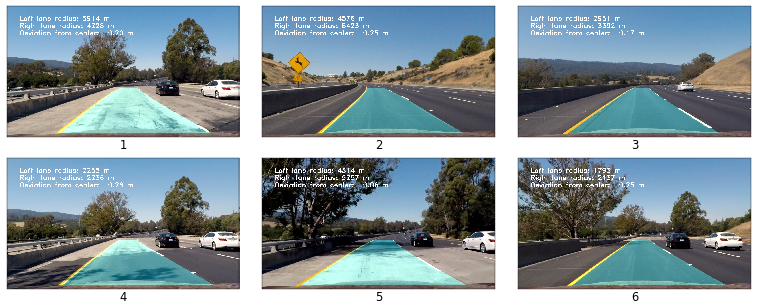

In [31]:
final_images = [draw_shade(images[i], left_radii_positions[i][0], right_radii_positions[i][0],
               left_radii_positions[i][1], right_radii_positions[i][1],
               fit_parameters[i][0], fit_parameters[i][1]) for i in range(6)]
display_images(final_images)

---
## Step 7. Put Things Together

So far we have almost completed all the building blocks. However, a robust and smooth output would require the following additions:
- A sanity_check function to evaluate the detection result of each frame. If the detection results in reasonable values, save them in a queue to be used to average (filter) future results, Otherwise discard them and inform the pipeline the detection has failed.

- If the previous detection was successful, we do not have to run the next pixel search blindly through 'sliding_window()'. The fitting lines of the previous frame give a good estimation of where the lines are in the current frame. With this knowledge we can run the search much faster. The algorithm is implemented in the 'informed_search()' function below.  

- To share data between frames and communicate information such as the detection results, we need a Class to handle the job.  The 'Line()' class defined in the following code and its class methods will perform the relevant functions. We then instantiate the class and create two objects, left_line and right_line to be used in the final pipeline function 'process_image()'. 

In [32]:
def sanity_check(left_radius, left_pos, right_radius, right_pos):
    # Calculate relative difference between the left and right radius
    diff = abs(left_radius - right_radius)/(left_radius + right_radius)
    
    # Calculate line separation
    sepa = right_pos - left_pos
    
    # If the two radius are too different, or the lane separation
    # is not within certain range, fail the test
    if (diff > 0.3) or (sepa > 4.1) or (sepa <3.3):
        return False
    else:
        return True

Check the results of sanity_check(). One out of 6 test images failed the test:

In [33]:
sanity_check_results = [sanity_check(left_radii_positions[i][0],left_radii_positions[i][1],
                                    right_radii_positions[i][0],right_radii_positions[i][1])
                                    for i in range(6)]
sanity_check_results

[True, True, True, True, False, True]

informed_search() function - screening pixels based on knowledge from the previous frame, presumably a much faster algorithm compared to sliding_window(). The input and output formats are the same as the 'sliding_window()' function.  

In [34]:
def informed_search(binary, left_fit, right_fit, width):
    # Initialize output color binary map
    filtered = np.zeros((binary.shape[0],binary.shape[1],3), np.float32)
    
    # Prepare 2D coordinates for masks 
    yv, xv = np.mgrid[0:binary.shape[0],0:binary.shape[1]]
    lxv = left_fit[0]*yv**2 + left_fit[1]*yv + left_fit[2]
    rxv = right_fit[0]*yv**2 + right_fit[1]*yv + right_fit[2]
    
    # Make two masks to highlight the region of interest
    lmask = np.zeros_like(binary)
    rmask = np.zeros_like(binary)  
    lmask[(xv>(lxv-width/2)) & (xv <(lxv+width/2))] = 1
    rmask[(xv>(rxv-width/2)) & (xv <(rxv+width/2))] = 1
            
    # Update output color binary
    filtered[:,:,0] = lmask * binary
    filtered[:,:,2] = rmask * binary
    
    return filtered 

The cell below verifies the 'informed_search()' results, which are very similar to the one we got with 'sliding_windows()' previously.

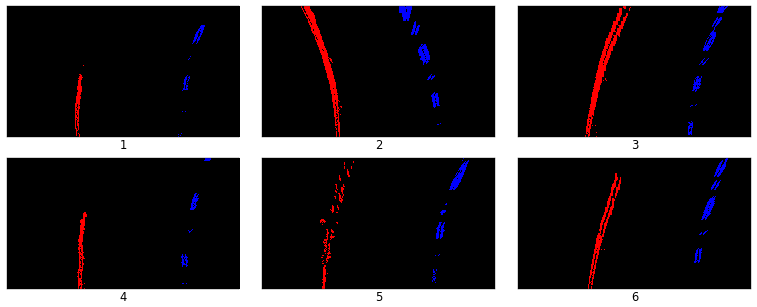

In [35]:
informed_search_results = [informed_search(warped_binaries[i], fit_parameters[i][0], fit_parameters[i][1], 100) 
                           for i in range(6)]
display_images(informed_search_results)

Define a Class to store previous data and communicate information between frames:

In [36]:
class Line():
    def __init__(self):
        # Detection status
        self.detected = False
        
        # Recent and best (average) radius values        
        self.recent_radii = []
        self.best_radius = None
        
        # Recent and best (average) position values
        self.recent_pos = []
        self.best_pos = None
        
        # Recent and best (average) fitting parameters
        self.recent_fit = []
        self.best_fit = None
        
    def reset(self):
        # Reset all variables to original values
        self.detected = False
        self.recent_radii = []
        self.best_radius = None
        self.recent_pos = []
        self.best_pos = None
        self.recent_fit = []
        self.best_fit = None
        
    def update(self, new_radius, new_pos, new_fit):
        # Set self.detected
        self.detected = True
        
        # Update list of recent records
        self.recent_radii.append(new_radius)
        self.recent_pos.append(new_pos)
        self.recent_fit.append(new_fit)
        
        # Remove the oldest record when the list gets enough length
        if len(self.recent_radii) > 10:
            self.recent_radii.pop(0)
            self.recent_pos.pop(0)
            self.recent_fit.pop(0)
            
        # Average the lists and update the best values
        self.best_radius = np.mean(self.recent_radii)
        self.best_pos = np.mean(self.recent_pos)
        self.best_fit = np.mean(self.recent_fit, axis=0)   

In [37]:
# Instantiate the class and create left_line and right_line objects
left_line = Line()
right_line = Line()

Now we are FINALLY ready to put everything together:

In [38]:
def process_image(img):
    # Image processing, from raw image to warped binary
    undistorted = undistort(img)
    binary = thresh(undistorted)
    warped_binary = warp(binary)
    
    # Select a method to filter the binary pixels depending on 
    # the last detection result
    if left_line.detected == False and right_line.detected == False:
        # If last detection failed, filter with sliding window
        color_binary = sliding_window(warped_binary,10,100)
    else:
        # Otherwise run an informed search using the best fitting
        # parameters in saved in the Line Class
        color_binary = informed_search(warped_binary, 
                                       left_line.best_fit,
                                       right_line.best_fit, 
                                       100)
    # Obtain fitting parameters
    left_fit, right_fit = fit_params(color_binary, 1, 1)
    
    # Get radii and positions: 
    left_radius, left_pos = radius_and_pos(left_fit)
    right_radius, right_pos = radius_and_pos(right_fit)
    
    # If sanity passes, update the line Class
    if sanity_check(left_radius, left_pos, right_radius, right_pos):
        left_line.update(left_radius, left_pos, left_fit)
        right_line.update(right_radius, right_pos, right_fit)
    # Otherwise reset self.detected and do nothing else    
    else:
        left_line.detected = False
        right_line.detected = False
    
    # Use the best values in the line Class to draw lines
    # and add annotations
    result = draw_shade(img, 
                        l_radius=left_line.best_radius, 
                        r_radius=right_line.best_radius, 
                        l_pos=left_line.best_pos, 
                        r_pos=right_line.best_pos, 
                        l_fit=left_line.best_fit, 
                        r_fit=right_line.best_fit)
    return result

The following codes are copied from CarND p1 to create a movie file and save it in the root directory as 'project_video_lines.mp4'

In [40]:
# Create video from "project_video.mp4"
project_output = 'project_video_lines.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_lines.mp4
[MoviePy] Writing video project_video_lines.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:05<00:00,  4.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lines.mp4 

Wall time: 6min 7s


---
## Discussions

The pipeline performs well on 'project_video.mp4', but not very satisfactory on 'challenge_video.mp4' or 'harder_challenge_video.mp4'. Even though the above codes provide a comprehensive set of functions, there is still plenty of room to improve in both prediction accuracy and speed. There are numerous hyperparameters we could play with: the threshold values for gradient and color thresholding and the type and amount of historical data to be stored in the class. How exactly shall we conduct the sanity check and how strict should it be? Shall we include historical data for sanity check? Can we make better use of the data from failed detection instead of simply discarding them? There are many open questions. Hope I can get time to revisit and refine this project in the future.